# Стандартные импорты

In [1]:
from IPython.display import clear_output
import os
import random
import multiprocessing
import gc
import pathlib
import shutil
from functools import reduce
from tqdm import tqdm, trange

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import cm
import pandas as pd
import numpy as np
from scipy.linalg import sqrtm
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from scipy.stats import norm, multivariate_normal
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.covariance import EllipticEnvelope
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostRegressor

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
import diffusers
from diffusers import DDPMScheduler
from diffusers.models.embeddings import get_timestep_embedding

In [2]:
import wandb

# Переменные

In [3]:
train_path = '../Input_data/train_cache.csv'
test_path = '../Input_data/test_cache.csv'

model_path = '../Models/n_hidden_1000_depth_3_batchsize_3030'
model_path = '../Models/model_baseline_1000'

discrepancy_path = '../Output_data/Discrepancy/'

In [ ]:
# wandb.login()
# wandb.init(project='diploma')

In [ ]:
# os.system('wandb offline')
# os.environ["WANDB_MODE"] = "offline" 

# Модель

In [69]:
@torch.no_grad()
def get_step(self, y, show_progress=False):
    x = torch.randn(y.shape[0], self.num_features, dtype=torch.float, device=self.device)
    y = torch.tensor(y, dtype=torch.float32, device=self.device).to(self.device)
    iterator = enumerate(self.step_scheduler.timesteps)
    iterator = tqdm(iterator) if show_progress else iterator
    for i, t in iterator:
        tt = t.expand(y.shape[0]).to(self.device)
        residual = self(x, y, tt)
        x = self.step_scheduler.step(residual, t, x).prev_sample
        if i == 980:
            return self.step_scheduler.step(residual, t, x)
    return x


In [70]:
class ConditionalLayer(nn.Module):
    def __init__(self, num_in, num_out, time_emb_size, cond_emb_size, max_period):
        super(ConditionalLayer, self).__init__()
        self.num_in = num_in
        self.time_emb_size = time_emb_size
        self.time_emb = nn.Sequential(
            nn.Linear(time_emb_size, time_emb_size),
            nn.ReLU(),
            nn.Linear(time_emb_size, time_emb_size),
        )
        self.cond_emb_size = cond_emb_size
        self.cond_enc = nn.Sequential(
            nn.LazyLinear(cond_emb_size),
            nn.BatchNorm1d(cond_emb_size),
            nn.ReLU(),
            nn.Linear(cond_emb_size, cond_emb_size),
            nn.BatchNorm1d(cond_emb_size),
            nn.ReLU(),
            nn.Linear(cond_emb_size, cond_emb_size),
        )
        self.num_out = num_out
        self.lin = nn.Sequential(
            nn.Linear(num_in + time_emb_size + cond_emb_size, num_out),
            nn.BatchNorm1d(num_out),
            nn.ReLU(),
            nn.Linear(num_out, num_out),
            nn.BatchNorm1d(num_out),
            nn.ReLU(),

        )
        self.max_period = max_period

    def forward(self, x, y, t):
        y_enc = self.cond_enc(y)
        time_enc = get_timestep_embedding(t, self.time_emb_size, max_period=self.max_period)
        time_enc = self.time_emb(time_enc)
        out = self.lin(torch.concat([x, y_enc, time_enc], dim=-1))
        return out


class LastLayer(ConditionalLayer):
    def __init__(self, num_in, num_out, time_emb_size, cond_emb_size, max_period):
            super(LastLayer, self).__init__(num_in, num_out, time_emb_size, cond_emb_size, max_period)
            self.lin = nn.Linear(num_in + time_emb_size + cond_emb_size, num_out)

class BaseDiffusionBody(nn.Module):
    def __init__(
            self, max_period, num_features=10,
            n_hidden=100, depth=1,
            time_emb_size=10, cond_emb_size=10,
    ):
        super(BaseDiffusionBody, self).__init__()
        self.max_period = max_period
        self.num_features = num_features
        self.cond_emb_size = cond_emb_size
        self.time_emb_size = time_emb_size
        layers = [ConditionalLayer(num_features, n_hidden, time_emb_size, cond_emb_size, max_period)]
        for i in range(depth):
            layers.append(ConditionalLayer(n_hidden, n_hidden, time_emb_size, cond_emb_size, max_period))
        self.layers = nn.ModuleList(layers)
        self.out = LastLayer(n_hidden, num_features, time_emb_size, cond_emb_size, max_period)

    def forward(self, x, y, t):
        generator = enumerate(self.layers)
        i, layer = next(generator)
        x = layer(x, y, t)
        for i, layer in generator:
            x = x + layer(x, y, t)
        return self.out(x, y, t)


class BaseDiffusion(nn.Module):
    def __init__(
        self,
        num_features=10,
        max_period=100,
        step_scheduler=None,
        scheduler_kwargs=None,
        cond_emb_size=10,
        time_emb_size=10,
        body_kwargs=None,
        device=None,
        wandb_project=None
    ):
        """
        Basic class for diffusion.
        """
        super(BaseDiffusion, self).__init__()

        self.num_features = num_features
        if step_scheduler is None:
            step_scheduler = DDPMScheduler
        if scheduler_kwargs is None:
            scheduler_kwargs = {'clip_sample': False}

        self.step_scheduler = step_scheduler(num_train_timesteps=max_period, **scheduler_kwargs)

        if body_kwargs is None:
            body_kwargs = {'n_hidden': 100, 'depth': 2}
        body_kwargs['cond_emb_size'] = cond_emb_size
        body_kwargs['time_emb_size'] = time_emb_size
        body_kwargs['num_features'] = num_features

        self.body = BaseDiffusionBody(max_period=max_period, **body_kwargs)

        self.loss = nn.MSELoss()
        self.device = device if device is not None else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)
        
        self.wandb_project = wandb_project

    def forward(self, X, y, t):
        """
        X: [bs, num_features]
        y: [bs]
        t: [bs]
        """
        return self.body(X, y, t)  # [bs, num_features]

    @torch.no_grad()
    def sample(self, y, show_progress=False):
        x = torch.randn(y.shape[0], self.num_features, dtype=torch.float, device=self.device)
        y = torch.tensor(y, dtype=torch.float32, device=self.device).to(self.device)
        iterator = enumerate(self.step_scheduler.timesteps)
        iterator = tqdm(iterator) if show_progress else iterator
        for i, t in iterator:
            tt = t.expand(y.shape[0]).to(self.device)
            residual = self(x, y, tt)
            x = self.step_scheduler.step(residual, t, x).prev_sample
        return x

    @torch.no_grad()
    def _pred_list(self, y, show_progress=False):
        x = torch.randn(y.shape[0], self.num_features, dtype=torch.float, device=self.device)
        y = torch.tensor(y, dtype=torch.float32, device=self.device).to(self.device)
        x_list = list()
        residual_list = list()
        iterator = enumerate(self.step_scheduler.timesteps)
        iterator = tqdm(iterator) if show_progress else iterator
        for i, t in iterator:
            tt = t.expand(y.shape[0]).to(self.device)
            residual = self(x, y, tt)
            step = self.step_scheduler.step(residual, t, x)
            x = step.prev_sample
            x_list.append(step.pred_original_sample)
        return x_list

    @torch.no_grad()
    def sample_best_steps(self, y, best_steps, return_last_step=False, show_progress=False):
        x = torch.randn(y.shape[0], self.num_features, dtype=torch.float, device=self.device)
        x_return = [torch.zeros_like(x) for _ in best_steps] if isinstance(best_steps, list) else torch.zeros_like(x) 
        y = torch.tensor(y, dtype=torch.float32, device=self.device).to(self.device)
        
        iterator = enumerate(self.step_scheduler.timesteps)
        iterator = tqdm(iterator) if show_progress else iterator
        
        max_timestep = self.step_scheduler.timesteps[0]
        for i, t in iterator:
            tt = t.expand(y.shape[0]).to(self.device)
            residual = self(x, y, tt)
            step = self.step_scheduler.step(residual, t, x)
            x = step.prev_sample
            
            if isinstance(x_return, list):
                for i, best_step in enumerate(best_steps):
                    step_condition = (best_step == max_timestep - t)
                    x_return[i][step_condition] = step.pred_original_sample[step_condition]
            else:
                step_condition = (best_step == max_timestep - t)
                x_return[step_condition] = step.pred_original_sample[step_condition]
            
        if return_last_step == True:
            return x_return, x
        return x_return

    def configure_optimizer(self, learning_rate=1e-3, optimizer=None, lr_scheduler=None):
        self.optimizer = (
            torch.optim.AdamW(self.parameters(), lr=learning_rate)
            if optimizer is None else optimizer
        )
        self.lr_scheduler = (
            torch.optim.lr_scheduler.MultiStepLR(
                self.optimizer, 
                milestones=[
                    500, 700, 1000, 1500, 
                    2000, 3000, 4000, 5000,
                    7000, 10000, 13000, 16000
                ], 
                gamma=0.15
            )
            if optimizer is None else optimizer
        )

    def fit(self, X, y, learning_rate=1e-3,
            epochs=10, batch_size=32):
        """TODO"""
        self.configure_optimizer(learning_rate=learning_rate)
        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float32, device=self.device)
        y_cond = torch.tensor(y, dtype=torch.float32, device=self.device)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.train(True)

        self.loss_history = []
        
        if self.wandb_project is not None:
            wandb.login()
            wandb.init(project=self.wandb_project)
            wandb.watch(self)

        for epoch in trange(epochs):
            loss_epoch = 0

            for i, (real_batch, cond_batch) in enumerate(
                    DataLoader(dataset_real, batch_size=batch_size, shuffle=True)
            ):
                noise = torch.randn_like(real_batch)
                timesteps = torch.randint(0, self.step_scheduler.timesteps[0] + 1, [cond_batch.shape[0]]).long().to(
                    self.device)
                noisy_batch = self.step_scheduler.add_noise(real_batch, noise, timesteps)

                self.optimizer.zero_grad()
                noise_pred = self(noisy_batch, cond_batch, timesteps)
                gen_loss = self.loss(noise, noise_pred)
                gen_loss.backward()
                self.optimizer.step()

                loss_epoch += gen_loss

            self.lr_scheduler.step()
            loss = loss_epoch.detach().cpu() / (i + 1)
            self.loss_history.append(loss)
            
            wandb.log({'train_loss': loss})
        
        wandb.finish()
        # Turn off training
        self.train(False)

# Данные

In [8]:
def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(5 * 4, 5 * 2))
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i + 1)
        plt.grid()
        plt.hist(X1[:, i], bins=bins, alpha=0.3, label=label1, color="C4")
        plt.hist(X2[:, i], bins=bins, alpha=0.3, label=label2, color="C0")
        plt.xlabel(names[i], size=14)
        plt.legend(loc="best")
    plt.tight_layout()


In [9]:
def prepare_data(data_path='data/train_cache.csv', **read_csv_options):
    """Читает данные, делает числами и помечает аутлаеры"""
    detector = EllipticEnvelope(contamination=0.02)

    data = pd.read_csv(data_path, **read_csv_options)
    data_target = data[['iops', 'lat']]

    data_feats = (
        data[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type']]
        .assign(io_type=data['io_type'].apply(lambda x: int(x == 'read')))
    )
    inliers = pd.Series(None, index=data.index, dtype=pd.Float64Dtype)
    for _, row in data_feats.drop_duplicates().iterrows():
        tmp_target = data_target[
            reduce(lambda a, b: a & b, [data_feats[col] == row[col] for col in row.keys()])
        ]
        inliers.loc[tmp_target.index] = detector.fit_predict(tmp_target)

    return data_feats.to_numpy(), data_target.to_numpy(), inliers.to_numpy()

In [10]:
train_data = pd.read_csv(train_path)

pre_train_feats, pre_train_target, train_inliers = prepare_data(train_path)
train_feats = pre_train_feats[train_inliers == 1]
train_target = pre_train_target[train_inliers == 1]

test_feats, test_target, _ = prepare_data(test_path)

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

target_scaler = Pipeline(
    steps=[
        ('scaler', FunctionTransformer(np.log, np.exp)),
        ('transformer', StandardScaler()),
        ('regressor', None)
    ]
)
train_target = target_scaler.fit_transform(train_target)
pre_train_target = target_scaler.transform(pre_train_target)
test_target = target_scaler.transform(test_target)

feats_scaler = StandardScaler()
train_feats = feats_scaler.fit_transform(train_feats)
pre_train_feats = feats_scaler.transform(pre_train_feats)
test_feats = feats_scaler.transform(test_feats)

In [12]:
train_data = pd.read_csv(train_path)

pre_train_unscaled_feats, pre_train_unscaled_target, train_inliers = prepare_data(train_path)
train_unscaled_feats = pre_train_unscaled_feats[train_inliers == 1]
train_unscaled_target = pre_train_unscaled_target[train_inliers == 1]

# Бейзлайн

## Обучение

100%|██████████| 20000/20000 [4:36:49<00:00,  1.20it/s]  


train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,0.00469


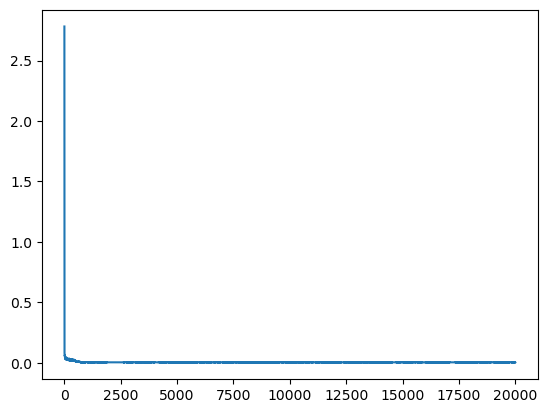

last loss: tensor(0.0047)
min loss: tensor(0.0038)
min loss index: 15543


In [22]:
model = BaseDiffusion(
    num_features=2,
    max_period=1000,
    step_scheduler=None,
    scheduler_kwargs=None,
    cond_emb_size=300,
    time_emb_size=500,
    body_kwargs = {'n_hidden': 1000, 'depth': 3},
)
model.to(model.device)
model.fit(train_target, train_feats, epochs=20000, learning_rate=1e-3, batch_size=3030)

plt.plot(model.loss_history)
plt.show()
print('last loss:', model.loss_history[-1])
print('min loss:', min(model.loss_history))
print('min loss index:', np.argmin(model.loss_history))

In [ ]:
plt.plot(model.loss_history)
plt.grid()
plt.yscale('log')
plt.xscale('log')

In [24]:
torch.save(model.state_dict(), model_path)
del model
torch.cuda.empty_cache()
gc.collect()

19096

## Старая стабильная модель

In [71]:
model = BaseDiffusion(
    num_features=2,
    max_period=1000,
    step_scheduler=None,
    scheduler_kwargs=None,
    cond_emb_size=300,
    time_emb_size=500,
    body_kwargs = {'n_hidden': 300, 'depth': 3,},
)
model.to(model.device)
model.load_state_dict(torch.load(model_path, map_location=model.device))
model.eval()
_ = 1

/home/dpkopytov/.conda/envs/diploma_env/lib/python3.8/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


# Валидация

In [23]:
train_gen_target = model.sample(train_feats).cpu().numpy()
test_gen_target = model.sample(test_feats).cpu().numpy()

In [24]:
X_train = np.concatenate(
    [
        np.concatenate(
            [target_scaler.inverse_transform(train_gen_target),
            feats_scaler.inverse_transform(train_feats)],
            axis=1
        ),
        np.concatenate(
            [target_scaler.inverse_transform(train_target),
            feats_scaler.inverse_transform(train_feats)],
            axis=1
        )
    ],
    axis=0
)
X_test = np.concatenate(
    [
        np.concatenate(
            [target_scaler.inverse_transform(test_gen_target),
            feats_scaler.inverse_transform(test_feats)],
            axis=1
        ),
        np.concatenate(
            [target_scaler.inverse_transform(test_target),
            feats_scaler.inverse_transform(test_feats)],
            axis=1
        )
    ],
    axis=0
)

y_train = np.array([0] * len(train_gen_target) + [1] * len(train_target))
y_test = np.array([0] * len(test_gen_target) + [1] * len(test_target))


In [25]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)

# получаем прогнозы
y_test_proba = clf.predict_proba(X_test)[:, 1]


In [26]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test, y_test_proba)
print("ROC AUC = ", auc)


ROC AUC =  0.49448642017667116


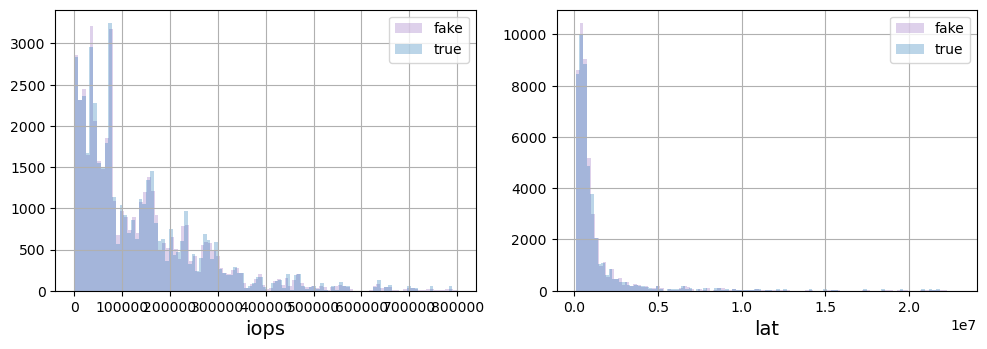

In [27]:
plot_hists(target_scaler.inverse_transform(train_gen_target), target_scaler.inverse_transform(train_target), ["iops", "lat"], label1="fake", label2="true", bins=100)

# Расчёт дисперсии предсказаний

Код взят из probaforms

## frechet_distance

In [13]:
def frechet_distance(X_real, X_fake, n_iters=100, standardize=False):
    '''
    Calculates the Frechet Distance between real and fake samples.

    Parameters:
    -----------
    X_real: numpy.ndarray of shape [n_samples, n_features]
        Real sample.
    X_fake: numpy.ndarray of shape [n_samples, n_features]
        Generated sample.
    n_iters: int
        The number of bootstrap iterations. Default = 100.
    standardize: boolean
        If True, the StandardScaler is fitted on the real and
        applied to the real and fake samples. Default = False.

    Return:
    -------
    distance: float
        The estimated Frechet Distance.
    Std: fload
        The standard deviation of the distance.
    '''

    frd = []

    if standardize:
        X_scaler = StandardScaler()
        X_real = X_scaler.fit_transform(X_real)
        X_fake = X_scaler.transform(X_fake)

    for i in range(n_iters):

        X_real_boot = resample(X_real)
        X_fake_boot = resample(X_fake)

        X_real_mean, X_real_cov = X_real_boot.mean(axis=0), np.cov(X_real_boot, rowvar=False)
        X_fake_mean, X_fake_cov = X_fake_boot.mean(axis=0), np.cov(X_fake_boot, rowvar=False)

        if X_real_boot.shape[1] == 1:
            X_real_cov = np.array([[X_real_cov]])
        if X_fake_boot.shape[1] == 1:
            X_fake_cov = np.array([[X_fake_cov]])

        diff = np.sum((X_real_mean - X_fake_mean)**2.0)
        covmean, _ = sqrtm(X_real_cov.dot(X_fake_cov), disp=False)

        if np.iscomplexobj(covmean): covmean = covmean.real
        tr_covmean = np.trace(covmean)

        ifrd = diff + np.trace(X_real_cov) + np.trace(X_fake_cov) - 2 * tr_covmean
        frd.append(ifrd)

    frd = np.array(frd)
    return frd.mean(axis=0), frd.std(axis=0)

## negative_loglike

In [46]:
def neg_ll(y_true, y_pred):
    ll = -multivariate_normal.logpdf(y_true, np.mean(y_pred, axis=0), np.cov(y_pred, rowvar=False)).mean()
    return ll

def negative_loglike(X_real, X_fake, n_iters=100, standardize=False):
    '''
    Calculates the negaative log likelihood between real and fake samples.

    Parameters:
    -----------
    X_real: numpy.ndarray of shape [n_samples, n_features]
        Real sample.
    X_fake: numpy.ndarray of shape [n_samples, n_features]
        Generated sample.
    n_iters: int
        The number of bootstrap iterations. Default = 100.
    standardize: boolean
        If True, the StandardScaler is fitted on the real and
        applied to the real and fake samples. Default = False.

    Return:
    -------
    distance: float
        The estimated Frechet Distance.
    Std: fload
        The standard deviation of the distance.
    '''

    nll = []

    if standardize:
        X_scaler = StandardScaler()
        X_real = X_scaler.fit_transform(X_real)
        X_fake = X_scaler.transform(X_fake)

    for i in range(n_iters):

        X_real_boot = resample(X_real)
        X_fake_boot = resample(X_fake)
        
        inll = neg_ll(X_real_boot, X_fake_boot)
        
        nll.append(inll)

    nll = np.array(nll)
    return nll.mean(axis=0), nll.std(axis=0)

## Расчёт выборки для обучения предиктора лучшего шага

Ожидаются датасеты для тренировочной и валидационной выборок с полями:
- id (внутренний идентификатор машины)
- io_type (это и предыдущее поля вместе однозначно задают параметры)
- step (шаг генерации)
- var (дисперсия предсказания)
- mean (среднее предсказание)
- div (дивегренция)

На гугл диске по одной модели считал MMD, здесь посчитаю FD, NLL

In [19]:
preds_path = '../Output_data/Predictions/baseline_x_list_to_save'
train_data = pd.read_csv(train_path)

# x_list = model._pred_list(pre_train_feats)
# x_list_cpu = [x.cpu().unsqueeze(dim=0) for x in x_list]
# x_list_to_save = torch.cat(x_list_cpu, axis=0)
# torch.save(x_list_to_save, preds_path)

In [20]:
x_list_cpu = torch.load(preds_path)

In [21]:
id_list = train_data[['id', 'io_type']].drop_duplicates()
total = len(id_list)
true_target = train_target


In [19]:
def calculate_distance_dataframe(params, load_folder, metrics, x_list=x_list_cpu, drop_outliers=False):
    local_name = f"{params['id']}__{params['io_type']}.csv"
    local_path = load_folder + local_name
    train_data = pd.read_csv(train_path)
    
    # Подготовим выборки в зависимости от фильтрации выбросов
    if drop_outliers:
        using_data = (
            train_data[train_inliers == 1]
        ).reset_index()
        using_target = train_target
    else:
        using_data = train_data
        using_target = pre_train_target

    # Обрабатываем только несуществующие на диске файлы
    file = pathlib.Path(local_path)
    if not file.exists():
        # Здесь индексы в трейн дате и должны быть 
        using_ids = using_data[lambda x: (x.id == params[0]) & (x.io_type == params[1])].index
        using_sample = using_target[using_ids]
        
        x_ids = train_data[lambda x: (x.id == params[0]) & (x.io_type == params[1])].index
        pred_list = [x[x_ids].cpu().numpy() for x in x_list]
        discrepancy_list = [
            metrics(using_sample, pred_sample, standardize=True)
            for pred_sample in pred_list
        ]
        output_df = pd.DataFrame(columns=['id', 'io_type', 'mu', 'sigma'], index=range(1000))
        output_df['id'] = params['id']
        output_df['io_type'] = params['io_type']
        output_df[['mu', 'sigma']] = discrepancy_list
        output_df.to_csv(local_path, index_label='step')


In [20]:
nll_folder = discrepancy_path + "NegativeLoglikeInliers/"

def calculate_nll_dataframe(params, drop_outliers=True):
    return calculate_distance_dataframe(
        params=params, 
        load_folder=nll_folder, 
        x_list=x_list_cpu, 
        metrics=negative_loglike,
        drop_outliers=drop_outliers
    )

In [21]:
keys = list(x[1] for x in id_list.iterrows())

In [27]:
pool = multiprocessing.Pool(processes=10)
pool.map(calculate_nll_dataframe, keys)
pool.close()
pool.join()

# Обучаем регрессию на дивергенцию $D=f(t, x)$

### Сборка обучающей выборки

In [31]:
preds_path = '../Output_data/Predictions/baseline_x_list_to_save'
train_data = pd.read_csv(train_path)
# torch.save(x_list_to_save, preds_path)

x_list_from_load = torch.load(preds_path)

x_list_cpu = x_list_from_load

In [32]:
distance_folder = discrepancy_path + "NegativeLoglikeInliers/"

In [33]:
train_feats = (
    train_data
    [['id', 'io_type', 'block_size', 'n_jobs', 'iodepth', 'read_fraction']]
    .copy(deep=True)
    .drop_duplicates()
)

In [34]:
X_train, X_val = train_test_split(train_feats, random_state=2145)
X_train = pd.DataFrame(X_train, columns=train_feats.columns)
X_val = pd.DataFrame(X_val, columns=train_feats.columns)

In [35]:
X_train.shape, X_val.shape

((606, 6), (202, 6))

In [36]:
discrepancy_pdf = pd.DataFrame(columns=[])

directory = os.fsencode(distance_folder)
for i, file in enumerate(os.listdir(directory)):
    filename = os.fsdecode(file)
    if filename.endswith('.csv'):
        discrepancy_pdf = pd.concat([
            discrepancy_pdf,
            pd.read_csv(os.path.join(directory.decode(), filename))
        ], axis=0)

    clear_output(wait=True)

discrepancy_pdf.shape, discrepancy_pdf.columns.tolist()

((808000, 5), ['step', 'id', 'io_type', 'mu', 'sigma'])

In [37]:
train_data = pd.read_csv(train_path).reset_index()
train_feats = (
    train_data
    [['id', 'io_type', 'block_size', 'n_jobs', 'iodepth', 'read_fraction']]
    .copy(deep=True)
    .drop_duplicates()
)

X_train, X_val = train_test_split(train_feats, random_state=2145)
ids_train = X_train.merge(train_data, on=['id', 'io_type'])['index']
ids_val = X_val.merge(train_data, on=['id', 'io_type'])['index']


In [38]:
def get_train_val_split(discrepancy_pdf=discrepancy_pdf, random_state=2145, return_full=False):
    train_data = pd.read_csv(train_path).reset_index()
    
    train_feats = (
        train_data
        [['id', 'io_type', 'block_size', 'n_jobs', 'iodepth', 'read_fraction']]
        .copy(deep=True)
        .drop_duplicates()
    )
    
    X_train, X_val = train_test_split(train_feats, random_state=random_state)
    
    X_train = pd.DataFrame(X_train, columns=train_feats.columns)
    X_val = pd.DataFrame(X_val, columns=train_feats.columns)

    ids_train = X_train.merge(train_data, on=['id', 'io_type'])['index']
    ids_val = X_val.merge(train_data, on=['id', 'io_type'])['index']
    
    X_train = X_train.merge(discrepancy_pdf, on=['id', 'io_type'])
    X_val = X_val.merge(discrepancy_pdf, on=['id', 'io_type'])
    
    
    X_train['io_type'] = X_train['io_type'].apply(lambda x: int(x == 'read'))
    X_val['io_type'] = X_val['io_type'].apply(lambda x: int(x == 'read'))
    
    if return_full:
        X = train_feats.reset_index(drop=True)
        ids = X.merge(train_data, on=['id', 'io_type'])['index']
        X = X.merge(discrepancy_pdf, on=['id', 'io_type'])
        X['io_type'] = X['io_type'].apply(lambda x: int(x == 'read'))
        return X_train, X_val, X, ids_train, ids_val, ids

    
    return X_train, X_val, ids_train, ids_val
 

In [39]:
def get_test(test_path=test_path):
    test_data = (
        pd.read_csv(test_path)
        .assign(io_type=lambda x: (x.io_type == 'read').astype(int))
    )
    
    test_feats = (
        test_data
        [['id', 'io_type', 'block_size', 'n_jobs', 'iodepth', 'read_fraction']]
        .copy(deep=True)
        .drop_duplicates()
    )
    X_test = (
        test_feats.assign(key=0)
        .merge(
            pd.DataFrame(list(zip(range(1000), [0] * 1000)), columns=['step', 'key']), 
            on='key'
        )
        .drop('key', axis=1)
    )
    return X_test
    

In [40]:
last_predict = x_list_cpu[-1, :]

In [41]:
X_train, X_val, X, ids_train, ids_val, ids = get_train_val_split(random_state=2145, return_full=True)
X_test = get_test()

In [42]:
X_train.info(), X_val.info(), X_test.info(), X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606000 entries, 0 to 605999
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             606000 non-null  object 
 1   io_type        606000 non-null  int64  
 2   block_size     606000 non-null  int64  
 3   n_jobs         606000 non-null  int64  
 4   iodepth        606000 non-null  int64  
 5   read_fraction  606000 non-null  int64  
 6   step           606000 non-null  int64  
 7   mu             606000 non-null  float64
 8   sigma          606000 non-null  float64
dtypes: float64(2), int64(6), object(1)
memory usage: 41.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202000 entries, 0 to 201999
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             202000 non-null  object 
 1   io_type        202000 non-null  int64  
 2   block_size     202000 non-null  int64

(None, None, None, None)

### Построение случайной конфигурации

In [43]:
def visualize_random_triple(best_predict, last_predict, pre_train_target=pre_train_target, i=None):
    i = random.randint(0, best_predict.shape[0] // 60) if i is None else i
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))

    pre_train_target_back_scaled = target_scaler.inverse_transform(pre_train_target)
    pre_train_target_back_scaled = (
        pre_train_target_back_scaled
        [i * 60: (i + 1) * 60]
        [train_inliers[i * 60: (i + 1) * 60] == 1]
    )
    best_predict_back_scaled = target_scaler.inverse_transform(best_predict.cpu().numpy())
    best_predict_back_scaled = (
        best_predict_back_scaled
        [i * 60: (i + 1) * 60]
    )
    last_predict_back_scaled = target_scaler.inverse_transform(last_predict.cpu().numpy())
    last_predict_back_scaled = (
        last_predict_back_scaled
        [i * 60: (i + 1) * 60]
    )

    ax[0, 0].scatter(*pre_train_target_back_scaled.T, alpha=0.3, label='true_value')
    ax[0, 0].scatter(*best_predict_back_scaled.T, alpha=0.5, label='best_predicted_step', marker='x')
    ax[0, 0].scatter(*last_predict_back_scaled.T, alpha=0.5, label='last_predicted_step', marker='+')
    ax[0, 0].legend()
    ax[0, 0].title.set_text(f'all together, i = {i}')
    xlim = ax[0, 0].get_xlim()
    ylim = ax[0, 0].get_ylim()

    ax[1, 1].scatter(*pre_train_target_back_scaled.T, alpha=0.3, label='true_value', c='C0')
    ax[1, 0].scatter(*best_predict_back_scaled.T, alpha=0.5, label='best_predicted_step', c='orange', marker='x')
    ax[0, 1].scatter(*last_predict_back_scaled.T, alpha=0.5, label='last_predicted_step', c='green', marker='+')
    

    ax[1, 1].title.set_text('true_value')
    ax[1, 0].title.set_text('best_predicted_step')
    ax[0, 1].title.set_text('last_predicted_step')
    
    ax[1, 1].set_xlim(xlim)
    ax[1, 0].set_xlim(xlim)
    ax[0, 1].set_xlim(xlim)

    ax[1, 1].set_ylim(ylim)
    ax[1, 0].set_ylim(ylim)
    ax[0, 1].set_ylim(ylim)


### Доля улучшения прогноза

In [47]:
def calculate_performance(best_predict, last_predict, pre_train_target, metrics=negative_loglike):
    """
    metrics is the function of signature metrics(X_real, X_fake, n_iters=100, standardize=False)
    """
    k = 0
    sum_best_metrics = 0
    sum_last_metrics = 0
    for i in range(best_predict.shape[0] // 60):
        pre_train_target_back_scaled = target_scaler.inverse_transform(pre_train_target)
        pre_train_target_back_scaled = (
            pre_train_target_back_scaled
            [i * 60: (i + 1) * 60]
            [train_inliers[i * 60: (i + 1) * 60] == 1]
        )
        best_predict_back_scaled = target_scaler.inverse_transform(best_predict.cpu().numpy())
        best_predict_back_scaled = (
            best_predict_back_scaled
            [i * 60: (i + 1) * 60]
        )
        last_predict_back_scaled = target_scaler.inverse_transform(last_predict.cpu().numpy())
        last_predict_back_scaled = (
            last_predict_back_scaled
            [i * 60: (i + 1) * 60]
        )

        best_metrics, _ = metrics(
            X_real=pre_train_target_back_scaled,
            X_fake=best_predict_back_scaled,
            standardize=True
        )
        last_metrics, _ = metrics(
            X_real=pre_train_target_back_scaled,
            X_fake=last_predict_back_scaled,
            standardize=True
        )

        sum_best_metrics += best_metrics
        sum_last_metrics += last_metrics
        if best_metrics < last_metrics:
            k += 1
    percentage = k / (i + 1)
    mean_best_metrics = sum_best_metrics / (i + 1)
    mean_last_metrics = sum_last_metrics / (i + 1)
    print(percentage, mean_best_metrics, mean_last_metrics, sep='\n')
    return percentage, mean_best_metrics, mean_last_metrics

## Предиктор постоянного лучшего шага

In [48]:
train_discr = X_train.groupby("step").agg({'mu': 'mean'})

In [49]:
best_t = np.argmin(train_discr['mu'])
best_t

998

In [50]:
best_predict_linreg = x_list_cpu[best_t, ids_val]

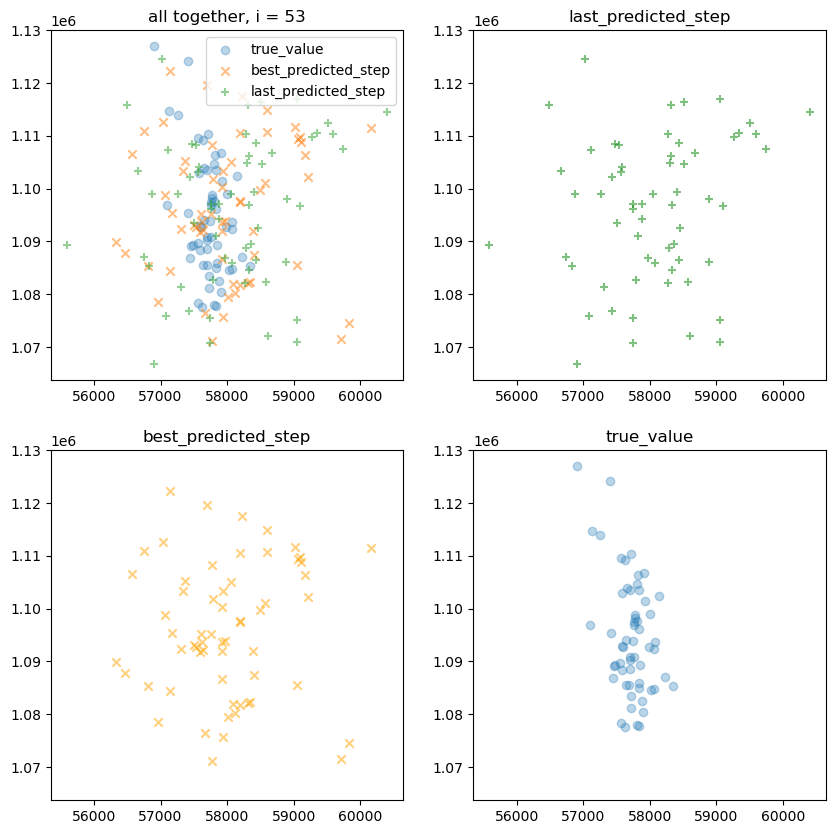

In [51]:
visualize_random_triple(best_predict_linreg, last_predict[ids_val], pre_train_target[ids_val], i=None)  # 103

In [52]:
persentage, mean_best_dist, mean_last_dist = calculate_performance(
    best_predict_linreg, 
    last_predict[ids_val], 
    pre_train_target[ids_val],
    metrics=negative_loglike
)

0.5841584158415841
8.85168104721158
6.53936966096711


In [53]:
full_discr = X.groupby("step").agg({'mu': 'mean'})

best_t = np.argmin(full_discr['mu'])
best_t

998

## Бустинг

In [54]:
def get_best_ts(data, estimator):
    """
    data: configuration like csv input files
    estimator: best step predictor
    
    """
    data = (
        data.drop_duplicates()
        .assign(io_type=lambda x: (x.io_type == 'read').astype(int))
    )
    
    feats = (
        data
        [['id', 'io_type', 'block_size', 'n_jobs', 'iodepth', 'read_fraction']]
        .copy(deep=True)
        .drop_duplicates()
    )
    X = (
        feats.assign(key=0)
        .merge(
            pd.DataFrame(list(zip(range(1000), [0] * 1000)), columns=['step', 'key']), 
            on='key'
        )
        .drop('key', axis=1)
    )
    data = X.drop(['id', 'mu', 'sigma'], axis=1, errors='ignore').to_numpy()

    pool = Pool(data)
    
    preds = np.exp(estimator.predict(pool))
    reshaped_preds = preds.reshape(-1, 1000)

    best_ts = np.argmin(reshaped_preds, axis=1)
    best_ts = torch.tensor(best_ts).unsqueeze(1).expand(data.shape[0] // 1000, 60).flatten()
    
    return best_ts

### Подбор параметров

In [105]:
# Нужно увеличить штрафы за ошибки при меленьких значениях таргета
train_data = X_train.drop(['id', 'mu', 'sigma'], axis=1).to_numpy()
train_regr = np.log(1 + np.log(X_train.mu))

val_data = X_val.drop(['id', 'mu', 'sigma'], axis=1).to_numpy()
val_regr = np.log(1 + np.log(X_val.mu))

# initialize Pool
train_pool = Pool(train_data, train_regr)
val_pool = Pool(val_data, val_regr)

# specify the training parameters 
boost = CatBoostRegressor(
    iterations=5000, 
    depth=8,
    grow_policy='Lossguide',
    # num_leaves=60,
    learning_rate=0.002, 
    loss_function='RMSE',
    random_seed=2145,
)
#train the model
boost.fit(train_pool, verbose=500, eval_set=val_pool)

0:	learn: 0.1548508	test: 0.1520444	best: 0.1520444 (0)	total: 89.5ms	remaining: 7m 27s
500:	learn: 0.0886531	test: 0.0878129	best: 0.0878129 (500)	total: 24.7s	remaining: 3m 41s
1000:	learn: 0.0676559	test: 0.0693572	best: 0.0693572 (1000)	total: 51.5s	remaining: 3m 25s
1500:	learn: 0.0593048	test: 0.0631337	best: 0.0631337 (1500)	total: 1m 19s	remaining: 3m 6s
2000:	learn: 0.0549961	test: 0.0605980	best: 0.0605980 (2000)	total: 1m 48s	remaining: 2m 43s
2500:	learn: 0.0520315	test: 0.0592671	best: 0.0592671 (2500)	total: 2m 19s	remaining: 2m 19s
3000:	learn: 0.0500644	test: 0.0585535	best: 0.0585535 (3000)	total: 2m 51s	remaining: 1m 53s
3500:	learn: 0.0485334	test: 0.0580652	best: 0.0580652 (3500)	total: 3m 22s	remaining: 1m 26s
4000:	learn: 0.0472836	test: 0.0576978	best: 0.0576976 (3999)	total: 3m 52s	remaining: 58.1s
4500:	learn: 0.0462291	test: 0.0574676	best: 0.0574676 (4500)	total: 4m 21s	remaining: 29s
4999:	learn: 0.0452990	test: 0.0573298	best: 0.0573294 (4994)	total: 4m 49s

In [191]:
# make the prediction using the resulting model
preds = np.exp(np.exp(boost.predict(val_pool)) - 1)
reshaped_preds = preds.reshape(-1, 1000)

best_ts = np.argmin(reshaped_preds, axis=1)
best_ts = torch.tensor(best_ts).unsqueeze(1).expand(X_val.shape[0] // 1000, 60).flatten()

In [192]:
reshaped_preds.shape

(202, 1000)

In [193]:
best_predict_cat = x_list_cpu[best_ts, ids_val]

In [194]:
persentage, mean_best_dist, mean_last_dist = calculate_performance(
    best_predict_cat, 
    last_predict[ids_val], 
    pre_train_target[ids_val], 
    metrics=negative_loglike
)

0.5297029702970297
14.273433494965694
6.628167767827152


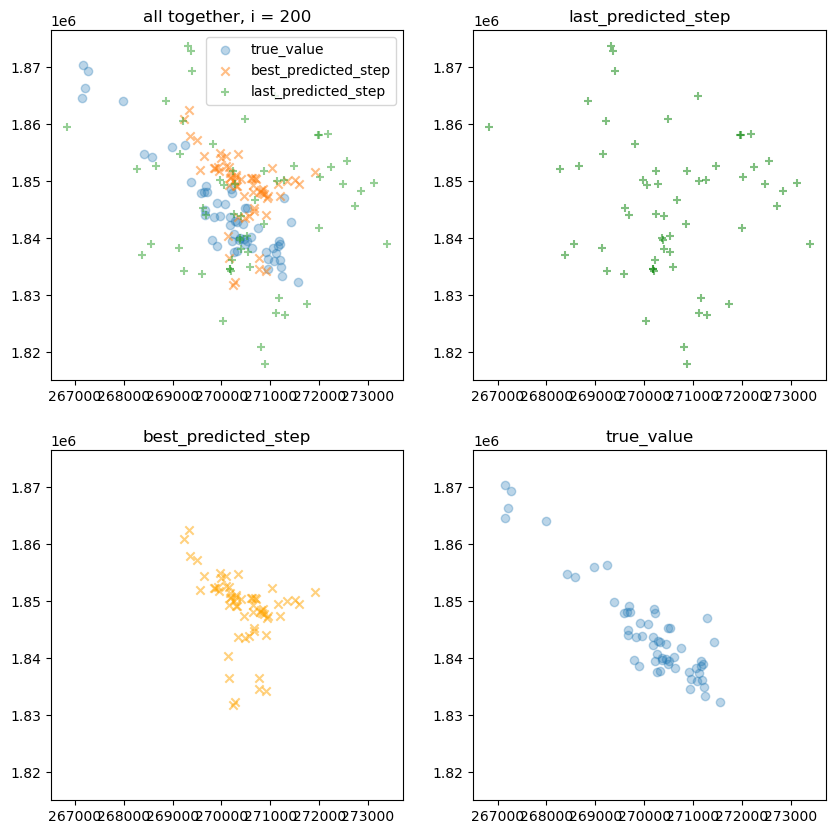

In [110]:
visualize_random_triple(best_predict_cat, last_predict[ids_val], pre_train_target[ids_val], i=200)

### Обучение на всей выборке

In [176]:
full_data = X.drop(['id', 'mu', 'sigma'], axis=1).to_numpy()
full_regr = np.log(1 + np.log(X.mu))

# initialize Pool
full_pool = Pool(full_data, full_regr)

# specify the training parameters 
boost = CatBoostRegressor(
    iterations=5000, 
    depth=8,
    grow_policy='Lossguide',
    # num_leaves=60,
    learning_rate=0.005, 
    loss_function='RMSE',
    random_seed=2145,
)
#train the model
boost.fit(full_pool, verbose=2500)

0:	learn: 0.1538134	total: 123ms	remaining: 10m 13s
2500:	learn: 0.0451906	total: 3m 1s	remaining: 3m 1s
4999:	learn: 0.0393849	total: 5m 15s	remaining: 0us


In [177]:
boost.save_model(
    '../Models/catboost_early_stop_estimator_2500_d7_l60_lr-3.cbm', 
    format="cbm",
    export_parameters=None,
    pool=None
)

### Построим предсказания на 5 семплах

In [178]:
train_data = X_train.drop(['id', 'mu', 'sigma'], axis=1).to_numpy()
train_regr = np.log(1 + np.log(X_train.mu))

val_data = X_val.drop(['id', 'mu', 'sigma'], axis=1).to_numpy()
val_regr = np.log(1 + np.log(X_val.mu))

# initialize Pool
train_pool = Pool(train_data, train_regr)
val_pool = Pool(val_data, val_regr)

boost1 = CatBoostRegressor().load_model('../Models/catboost_early_stop_estimator_2500_d7_l60_lr-3.cbm')

preds = np.exp(np.exp(boost1.predict(val_pool)) - 1)
reshaped_preds = preds.reshape(-1, 1000)

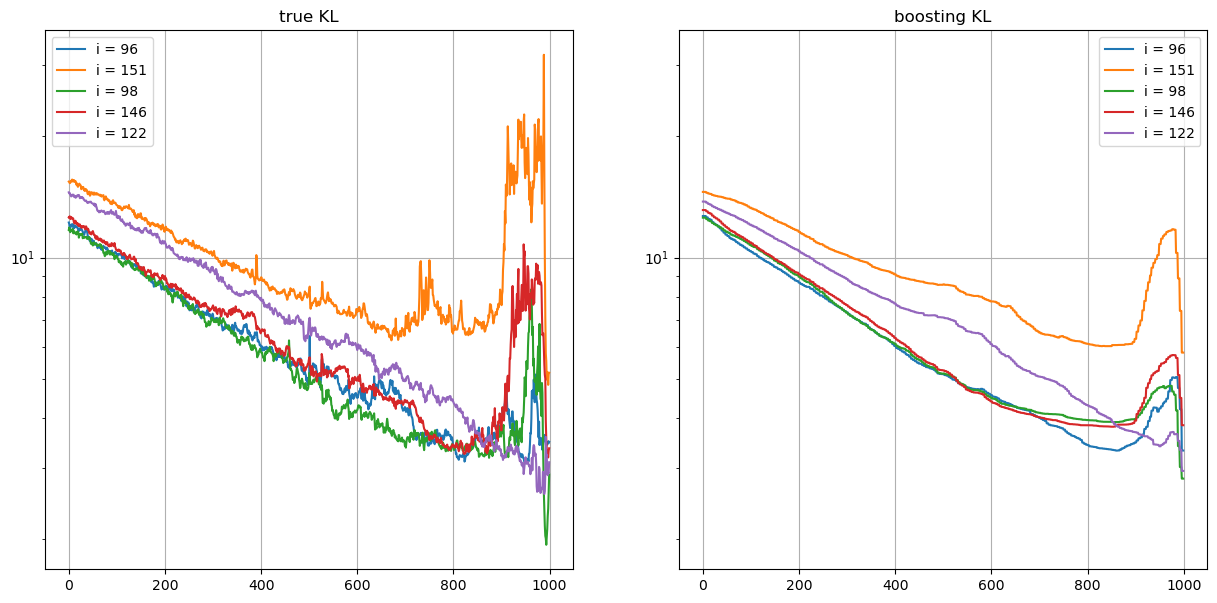

In [179]:
_, a = train_test_split(
    pd.read_csv(train_path)
    [['id', 'io_type', 'block_size', 'n_jobs', 'iodepth', 'read_fraction']]
    .copy(deep=True)
    .drop_duplicates(), 
    random_state=2145
)

kekekeys = [row for _, row in  a[['id', 'io_type']].iterrows()]


fig = plt.figure(figsize=(15, 7))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
for i in [96, 151, 98, 146, 122]:

    params = kekekeys[i]
    sample1 = pd.read_csv(f"../Output_data/Discrepancy/NegativeLoglikeInliers/{params['id']}__{params['io_type']}.csv")
    ax1.grid()
    ax1.title.set_text('true KL')
    ax1.plot(sample1['mu'], label=f'i = {i}')
    ax1.set_yscale('log')
    ax1.legend()
    
    sample2 = reshaped_preds[i]
    ax2.grid()
    ax2.title.set_text('boosting KL')
    ax2.plot(sample2, label=f'i = {i}')
    ax2.set_yscale('log')
    ax2.set_ylim(ax1.get_ylim())
    ax2.legend()

plt.show()

# Песочница

In [149]:
_, a = train_test_split(
    pd.read_csv(train_path)
    [['id', 'io_type', 'block_size', 'n_jobs', 'iodepth', 'read_fraction']]
    .copy(deep=True)
    .drop_duplicates(), 
    random_state=2145
)

kekekeys = [row for _, row in  a[['id', 'io_type']].iterrows()]

[kekekeys[i] for i in [96, 151, 98, 146, 122]]

[id         hse-09132022-110720-z92579
 io_type                          read
 Name: 7200, dtype: object,
 id         hse-09132022-165306-z97423
 io_type                         write
 Name: 10740, dtype: object,
 id         hse-09132022-160459-z76290
 io_type                         write
 Name: 2760, dtype: object,
 id         hse-09132022-165443-z99348
 io_type                          read
 Name: 27960, dtype: object,
 id         hse-09132022-224006-z66619
 io_type                          read
 Name: 34980, dtype: object]

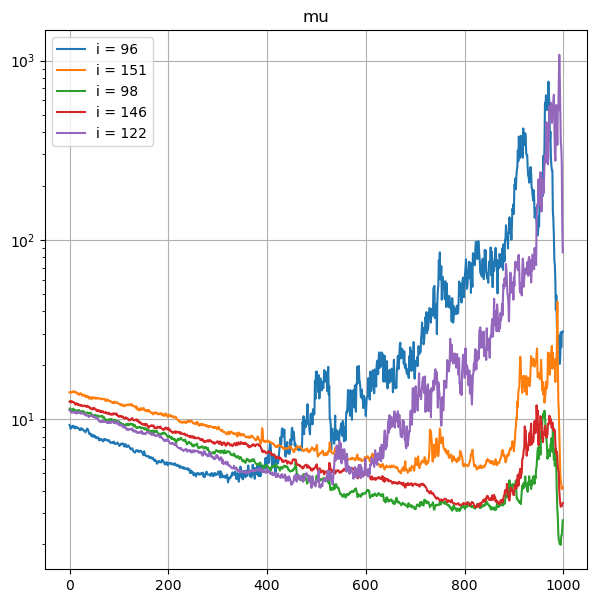

In [170]:
fig = plt.figure(figsize=(7, 7))
for i in [96, 151, 98, 146, 122]:
    params = kekekeys[i]
    sample = pd.read_csv(f"../Output_data/Discrepancy/NegativeLoglike/{params['id']}__{params['io_type']}.csv")
    plt.grid()
    plt.title(f'mu')
    plt.plot(sample['mu'], label=f'i = {i}')
    plt.yscale('log')
    plt.legend()


# Тест для метрик

In [122]:
reshaped_boost_pred_fd.shape

(202, 1000)

In [180]:
# best_step_boosting
boost = CatBoostRegressor().load_model('../Models/catboost_early_stop_estimator_2500_d7_l60_lr-3.cbm')

test_pool = Pool(X_test.drop(['id'], axis=1).to_numpy())

boost_pred_fd = np.exp(np.exp(boost.predict(test_pool)) - 1)
reshaped_boost_pred_fd = boost_pred_fd.reshape(-1, 1000)

best_test_ts = np.argmin(reshaped_boost_pred_fd[:, ::-1], axis=1, )
best_test_ts = torch.tensor(best_test_ts).unsqueeze(1).expand(X_test.shape[0] // 1000, 60).flatten()
best_test_ts.shape

torch.Size([12120])

In [181]:
best_test_ts = 999 - best_test_ts

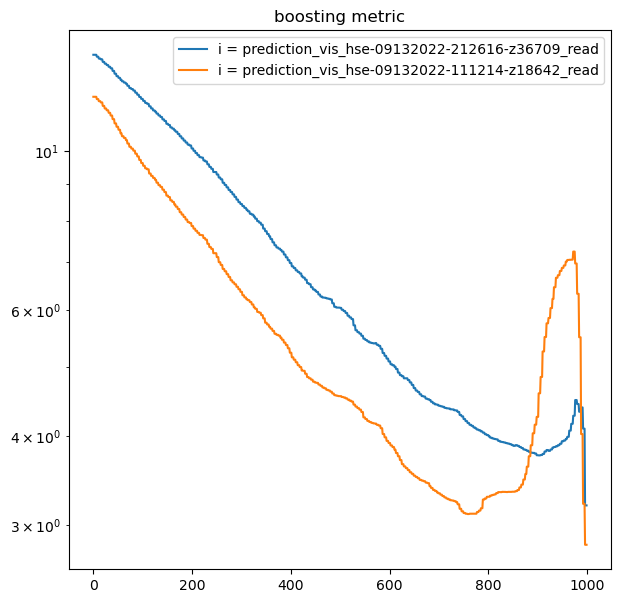

In [182]:
preds_for_pic = reshaped_boost_pred_fd[[2,32]]
fig = plt.figure(figsize=(7, 7))
for i, num in enumerate([
    "prediction_vis_hse-09132022-212616-z36709_read",
    "prediction_vis_hse-09132022-111214-z18642_read"
]):    
    sample2 = reshaped_preds[i]
    plt.grid()
    plt.title('boosting metric')
    plt.plot(preds_for_pic[i], label=f'i = {num}')
    plt.yscale('log')
    plt.legend()



In [183]:
pd.Series(best_test_ts).describe()

count    12120.000000
mean       973.079208
std         53.535336
min        745.000000
25%        999.000000
50%        999.000000
75%        999.000000
max        999.000000
dtype: float64

In [184]:
best_t = 998
# best_test_ts = bbb

In [185]:
[pred_best_step_boosting, pred_best_step_constant], pred_last_step = model.sample_best_steps(test_feats, [best_test_ts, best_t], return_last_step=True)

In [186]:
pred_best_step_boosting = pred_best_step_boosting.cpu().numpy()
pred_best_step_constant = pred_best_step_constant.cpu().numpy()
pred_last_step = pred_last_step.cpu().numpy()

In [187]:
output = pd.read_csv(test_path)
output[['gen_iops', 'gen_lat']] = target_scaler.inverse_transform(pred_best_step_boosting)

output_name = '../Output_data/Validation/negative_loglike_inliers_boosting.csv'
output.to_csv(output_name, float_format='%.2f', index=False)

In [188]:
output = pd.read_csv(test_path)
output[['gen_iops', 'gen_lat']] = target_scaler.inverse_transform(pred_best_step_constant)

output_name = '../Output_data/Validation/negative_loglike_inliers_constant.csv'
output.to_csv(output_name, float_format='%.2f', index=False)

In [189]:
output = pd.read_csv(test_path)
output[['gen_iops', 'gen_lat']] = target_scaler.inverse_transform(pred_last_step)

output_name = '../Output_data/Validation/baseline_last_step.csv'
output.to_csv(output_name, float_format='%.2f', index=False)

In [190]:
pd.read_csv(test_path).assign(best_step=pd.Series(best_test_ts))[pd.Series(best_test_ts) != 999].drop_duplicates(['id', 'io_type']).sample(5)

,iops,lat,block_size,n_jobs,iodepth,read_fraction,load_type,io_type,raid,n_disks,device_type,offset,id,best_step
5520,125812,900152.69,64,26,9,61,random,write,4+1,24,nvme,0,hse-09132022-201846-z96779,893
6840,5663,920336.29,256,34,2,92,random,write,4+1,24,nvme,0,hse-09142022-002903-z26645,811
600,314912,721909.60,8,30,16,63,random,read,4+1,24,nvme,0,hse-09132022-202959-z97080,905
10140,62771,417577.55,32,20,10,21,random,read,4+1,24,nvme,0,hse-09132022-144855-z14318,889
1740,274873,1237596.42,4,36,12,34,random,write,4+1,24,nvme,0,hse-09132022-163352-z28622,909


In [174]:
k = 5520 // 60

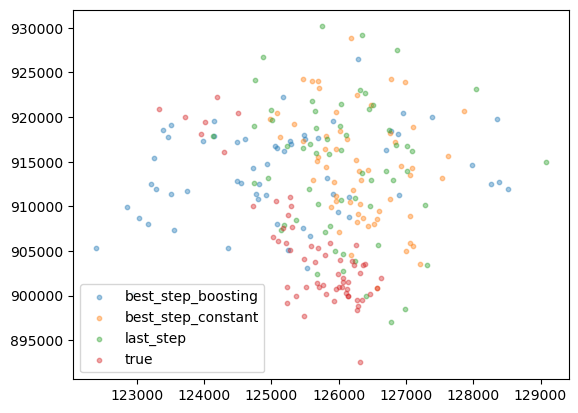

In [175]:
plt.scatter(*pd.read_csv('../Output_data/Validation/negative_loglike_inliers_boosting.csv').iloc[60 * k :60 * k + 60][['gen_iops', 'gen_lat']].to_numpy().T, alpha=0.4, s=10, label='best_step_boosting')

plt.scatter(*pd.read_csv('../Output_data/Validation/negative_loglike_inliers_constant.csv').iloc[60 * k :60 * k + 60][['gen_iops', 'gen_lat']].to_numpy().T, alpha=0.4, s=10, label='best_step_constant')

plt.scatter(*pd.read_csv('../Output_data/Validation/baseline_last_step.csv').iloc[60 * k :60 * k + 60][['gen_iops', 'gen_lat']].to_numpy().T, alpha=0.4, s=10, label='last_step')

plt.scatter(*pd.read_csv('../Output_data/Validation/baseline_last_step.csv').iloc[60 * k :60 * k + 60][['iops', 'lat']].to_numpy().T, alpha=0.4, s=10, label='true')

plt.legend()

In [79]:
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython import display
import matplotlib.pyplot as plt


In [87]:
a = (
    pd.read_csv(test_path)
    [['id', 'io_type', 'block_size', 'n_jobs', 'iodepth', 'read_fraction']]
    .copy(deep=True)
    .drop_duplicates()
)

kekekeys = [row for _, row in  a[['id', 'io_type']].iterrows()]

[kekekeys[i] for i in [1920 // 60]]

[id         hse-09132022-111214-z18642
 io_type                          read
 Name: 1920, dtype: object]

hse-09132022-212616-z36709 read


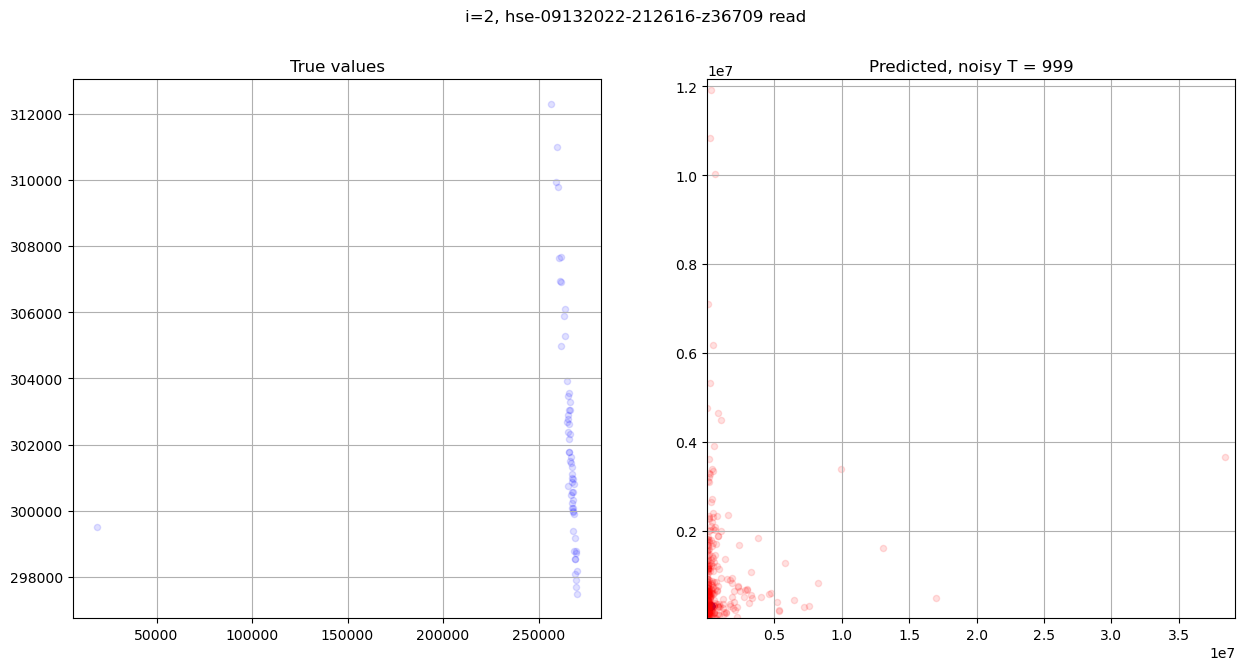

In [92]:
data = pd.read_csv(test_path)

target = test_target
feats = test_feats

for i in [2]:
    ID, io_type = kekekeys[i] 
    print(ID, io_type)

    x_true = target[(data.id == ID) & (data.io_type == io_type)]
    y_true = feats[(data.id == ID) & (data.io_type == io_type)]
    model = model 
    feats = y_true.repeat(5, axis=0)
    x_true = x_true
    alpha = 0.12
    s = 20
    plot_step=list(range(1000))

    x_list = model._pred_list(feats)
    x_true_transformed = target_scaler.inverse_transform(x_true)
    x_list_transformed = [target_scaler.inverse_transform(x.cpu().numpy()) for x in x_list]
    
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 7))
    fig.suptitle(f"i={i}, {ID} {io_type}")

    ax1.grid()
    scat1 = ax1.scatter(*x_true_transformed.T, color="blue", alpha=alpha, s=s)
    ax1.title.set_text(f'True values')

    ax2.grid()
    scat21 = ax2.scatter(*x_true_transformed.T, color="blue", alpha=alpha, s=s)
    scat22 = ax2.scatter(*x_list_transformed[0].T, color="red", alpha=alpha, s=s)
    ax2.title.set_text(f'Predicted, noisy T = {1000 - 1}')
    
    mins, maxs = x_true.min(axis=0), x_true.max(axis=0)
    iterator = (
        range(plot_step - 1, model.step_scheduler.timesteps.__len__(), plot_step)
        if isinstance(plot_step, int)
        else plot_step
    )


    def AnimationFunction(frame):
        df1 = x_true_transformed
        df2 = x_list_transformed[frame]

        scat1.set_offsets(df1)
        scat21.set_offsets(df1)
        scat22.set_offsets(df2)
        ax2.set_xlim()
        ax2.set_ylim()
        ax2.set_xlim(0.98 * np.min([df1[:, 0].min(), df2[:, 0].min()]), 1.02 * np.max([df1[:, 0].max(), df2[:, 0].max()]))
        ax2.set_ylim(0.98 * np.min([df1[:, 1].min(), df2[:, 1].min()]), 1.02 * np.max([df1[:, 1].max(), df2[:, 1].max()]))
        ax2.title.set_text(f'Predicted, noisy T = {1000 - frame - 1}')


    anim_created = FuncAnimation(fig, AnimationFunction, frames=iterator, interval=40)

    anim_created.save(f'prediction_vis_{ID}_{io_type}.gif')

# Визуализация

### Динамика генерации

In [ ]:
train_data = pd.read_csv(train_path)

_, a = train_test_split(
    train_data
    [['id', 'io_type', 'block_size', 'n_jobs', 'iodepth', 'read_fraction']]
    .copy(deep=True)
    .drop_duplicates(), 
    random_state=2145
)

kekekeys = [row for _, row in  a[['id', 'io_type']].iterrows()]

hse-09132022-110720-z92579 read
hse-09132022-165306-z97423 write
hse-09132022-160459-z76290 write
hse-09132022-165443-z99348 read
hse-09132022-224006-z66619 read


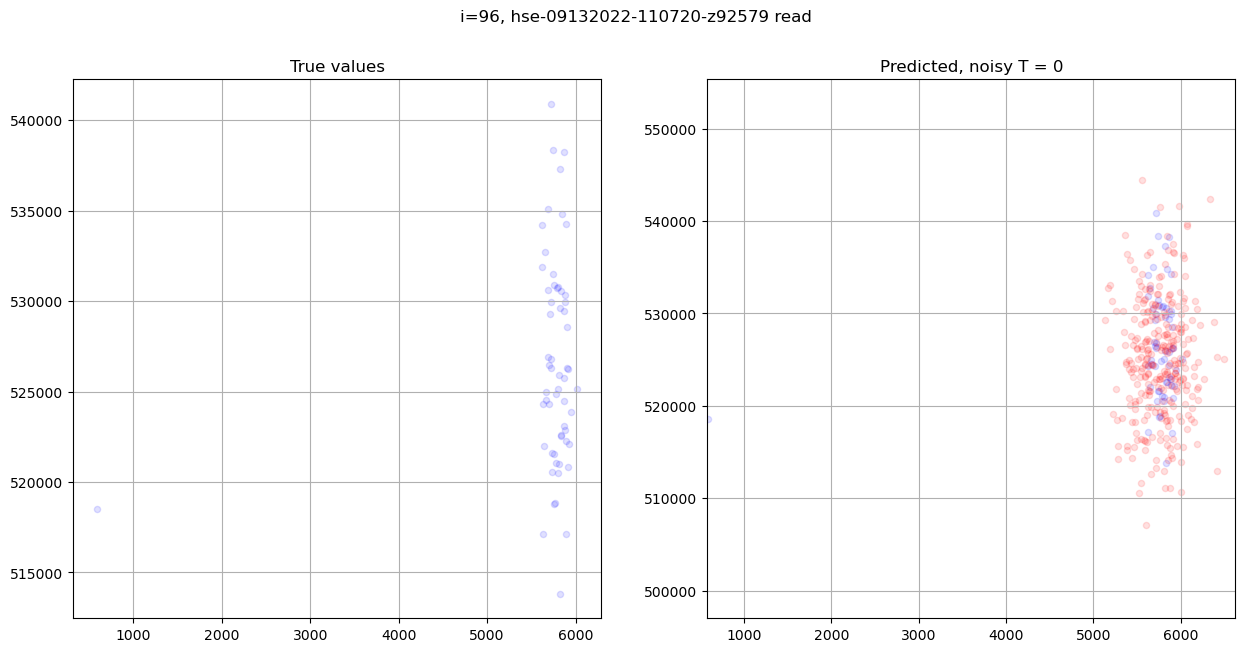

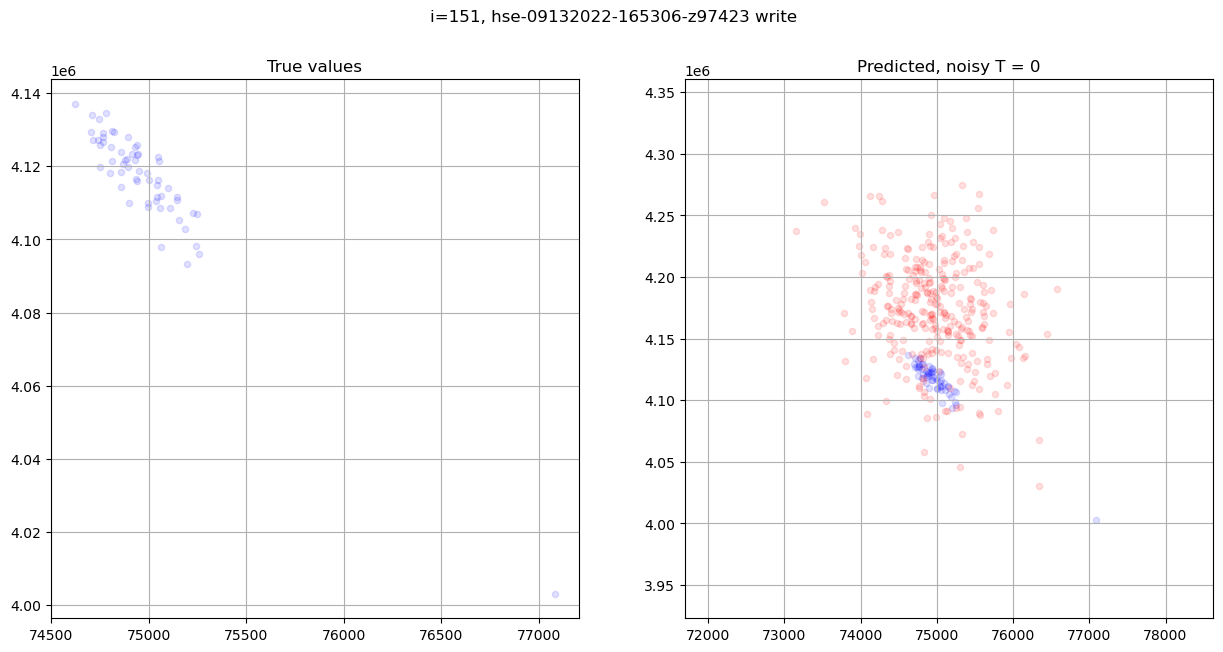

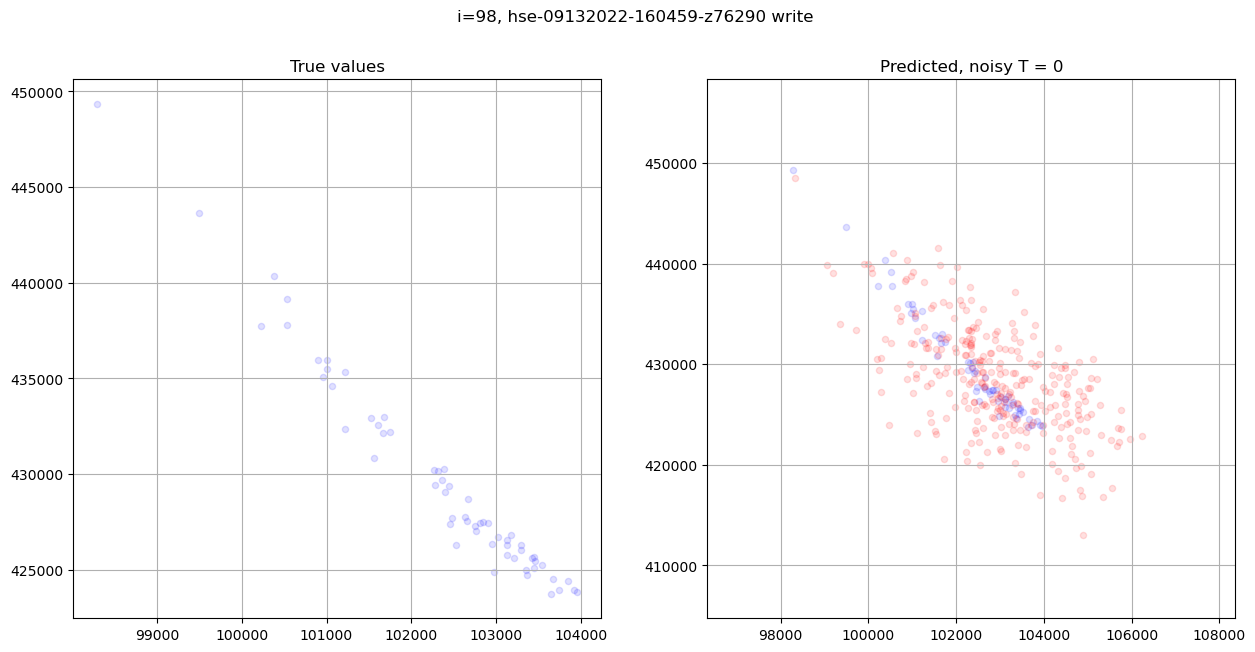

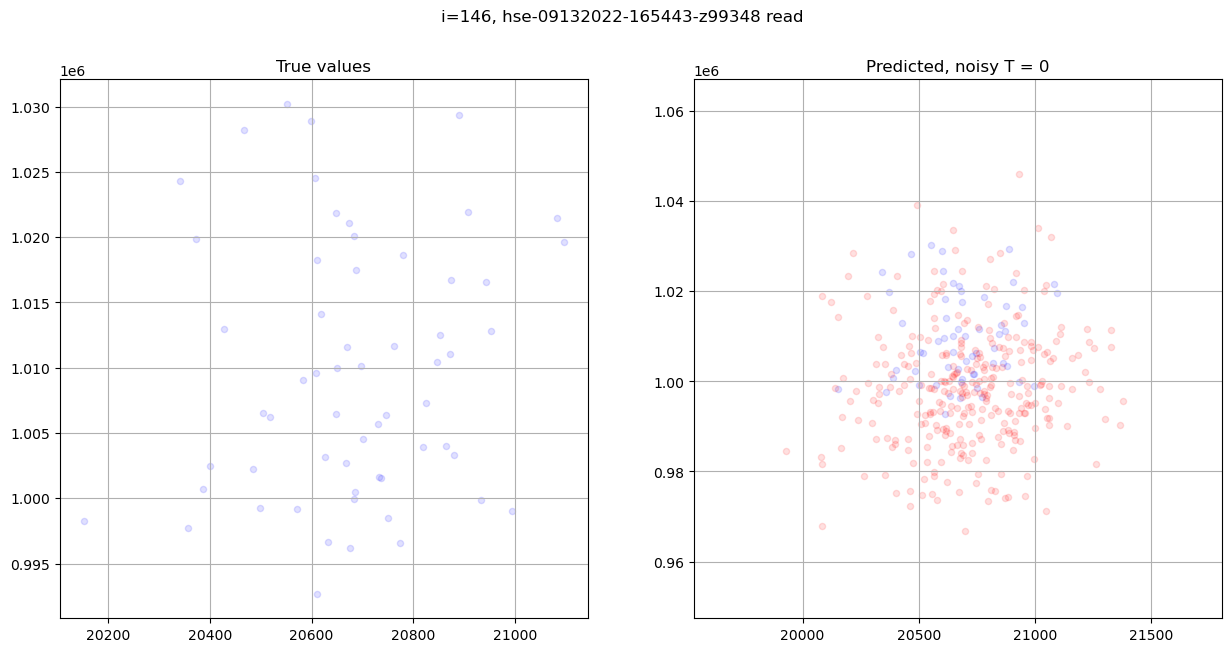

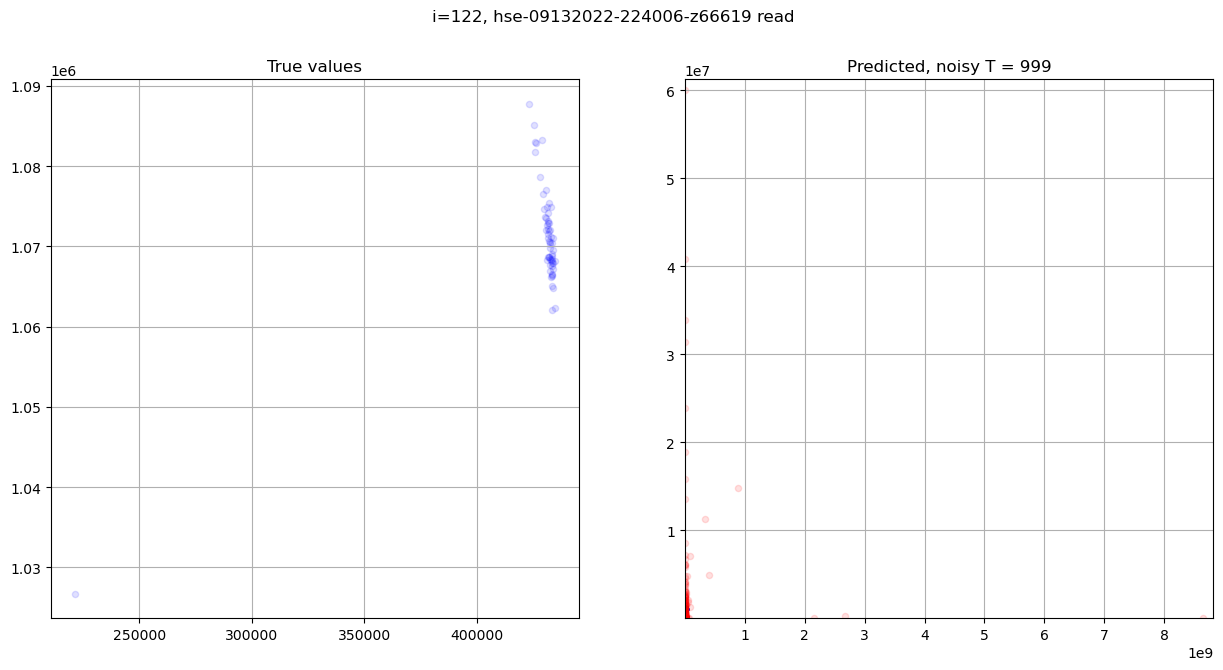

In [28]:
for i in [96, 151, 98, 146, 122]:
    ID, io_type = kekekeys[i] 
    print(ID, io_type)

    x_true = pre_train_target[(train_data.id == ID) & (train_data.io_type == io_type)]
    y_true = pre_train_feats[(train_data.id == ID) & (train_data.io_type == io_type)]
    model = model 
    feats = y_true.repeat(5, axis=0)
    x_true = x_true
    alpha = 0.12
    s = 20
    plot_step=list(range(1000))

    x_list = model._pred_list(feats)
    x_true_transformed = target_scaler.inverse_transform(x_true)
    x_list_transformed = [target_scaler.inverse_transform(x.cpu().numpy()) for x in x_list]
    
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 7))
    fig.suptitle(f"i={i}, {ID} {io_type}")

    ax1.grid()
    scat1 = ax1.scatter(*x_true_transformed.T, color="blue", alpha=alpha, s=s)
    ax1.title.set_text(f'True values')

    ax2.grid()
    scat21 = ax2.scatter(*x_true_transformed.T, color="blue", alpha=alpha, s=s)
    scat22 = ax2.scatter(*x_list_transformed[0].T, color="red", alpha=alpha, s=s)
    ax2.title.set_text(f'Predicted, noisy T = {1000 - 1}')
    
    mins, maxs = x_true.min(axis=0), x_true.max(axis=0)
    iterator = (
        range(plot_step - 1, model.step_scheduler.timesteps.__len__(), plot_step)
        if isinstance(plot_step, int)
        else plot_step
    )


    def AnimationFunction(frame):
        df1 = x_true_transformed
        df2 = x_list_transformed[frame]

        scat1.set_offsets(df1)
        scat21.set_offsets(df1)
        scat22.set_offsets(df2)
        ax2.set_xlim()
        ax2.set_ylim()
        ax2.set_xlim(0.98 * np.min([df1[:, 0].min(), df2[:, 0].min()]), 1.02 * np.max([df1[:, 0].max(), df2[:, 0].max()]))
        ax2.set_ylim(0.98 * np.min([df1[:, 1].min(), df2[:, 1].min()]), 1.02 * np.max([df1[:, 1].max(), df2[:, 1].max()]))
        ax2.title.set_text(f'Predicted, noisy T = {1000 - frame - 1}')


    anim_created = FuncAnimation(fig, AnimationFunction, frames=iterator, interval=40)

    anim_created.save(f'prediction_vis_{ID}_{io_type}.gif')

### Закон Литтла

In [21]:
little_law_ids = pd.read_csv(train_path)

little_law_ids = little_law_ids.groupby(['id', 'io_type']).agg({
    'io_type': 'first', 
    'iodepth': 'mean',
    'n_jobs': 'mean',
    'iops': 'mean',
    'lat': 'mean',
})

little_law_ids['x'] = little_law_ids.iodepth * little_law_ids.n_jobs
little_law_ids['y'] = little_law_ids.iops * little_law_ids.lat


little_law_ids = little_law_ids.groupby('id').agg({
    'x': 'mean',
    'y': 'sum',
    'io_type': 'nunique'
})

little_law_ids = little_law_ids[little_law_ids.io_type == 2]

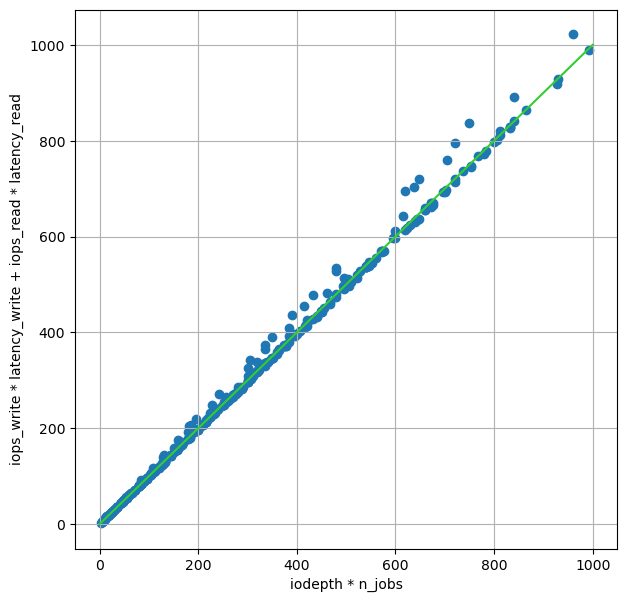

In [29]:
plt.figure(figsize=(7, 7))

plt.scatter(
    little_law_ids['x'],
    little_law_ids['y']/ 1e9,
)
plt.plot(np.linspace(0, 1000, 2), np.linspace(0, 1000, 2), c='limegreen')

plt.xlabel('iodepth * n_jobs')
plt.ylabel('iops_write * latency_write + iops_read * latency_read')

plt.grid()
plt.show()

### Таргет до и просле преобразования

In [13]:
lims = np.array([
    [1e3, 1e5],
    [10e3, 10e5]
])
transformed_lims = target_scaler.transform(lims)

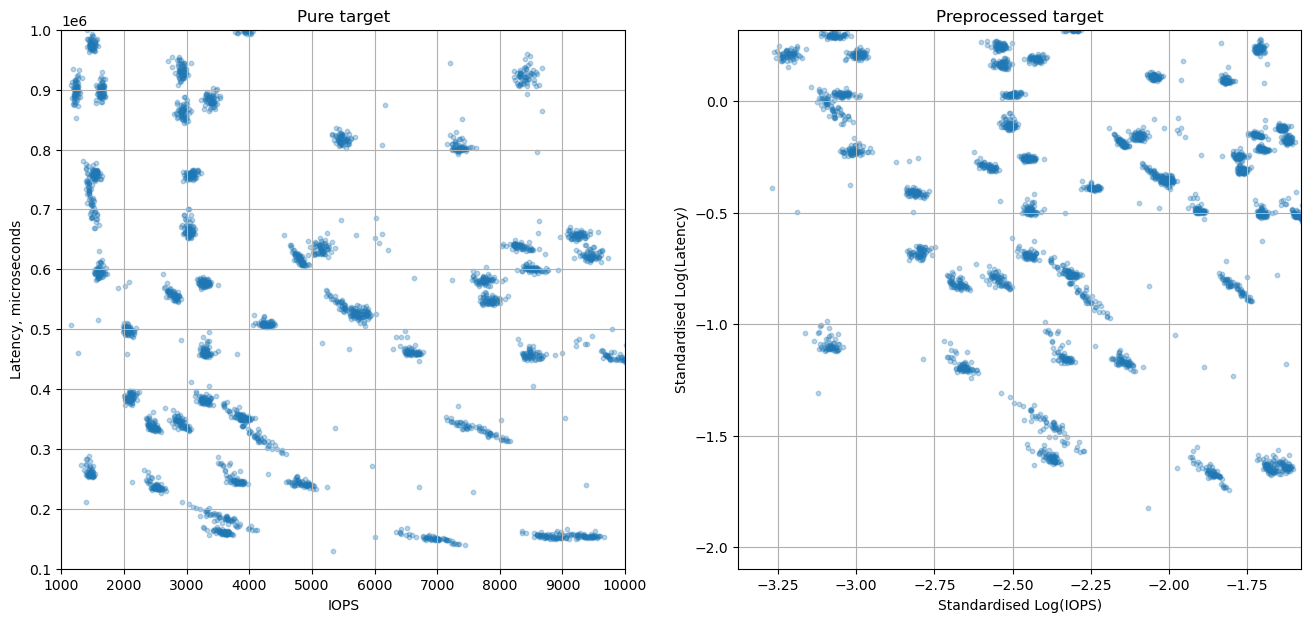

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(16, 7))

ax[0].grid()
ax[0].set_title('Pure target')
ax[0].scatter(*pre_train_unscaled_target.T, alpha=0.3, s=10)

ax[0].set_xlabel('IOPS')
ax[0].set_xlim(lims[:, 0])
ax[0].set_ylabel('Latency, microseconds')
ax[0].set_ylim(lims[:, 1])


ax[1].grid()
ax[1].set_title('Preprocessed target')
ax[1].scatter(*pre_train_target.T, alpha=0.3,s=10)

ax[1].set_xlabel('Standardised Log(IOPS)')
ax[1].set_xlim(transformed_lims[:, 0])
ax[1].set_ylabel('Standardised Log(Latency)')
ax[1].set_ylim(transformed_lims[:, 1])

plt.show()

### KL-distance графики

In [46]:
directory_in_str = "../Output_data/Discrepancy/NegativeLoglikeInliers/"

In [47]:
alpha = 0.1
s = 1
lw = 0.3

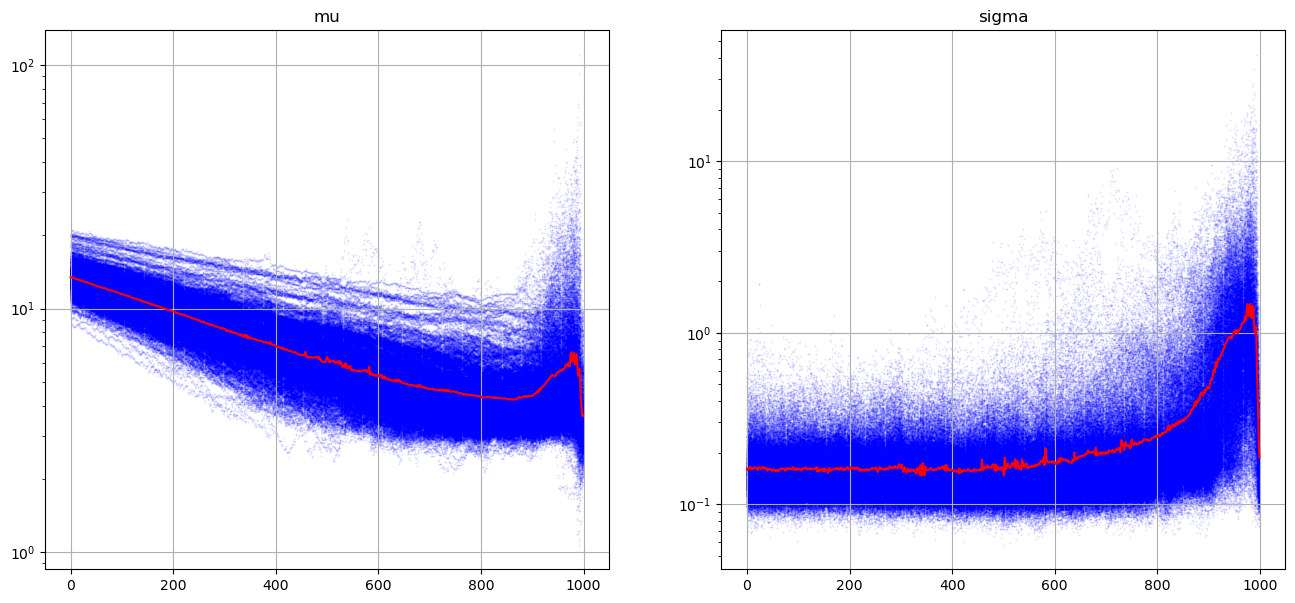

In [48]:
directory = os.fsencode(directory_in_str)

full_discr = pd.DataFrame(columns=['mu', 'sigma'], index=range(1000)).fillna(0.)

fig, ax = plt.subplots(1, 2, figsize=(16, 7))

ax[0].grid()
ax[0].set_title('mu')

ax[1].grid()
ax[1].set_title('sigma')

k = 0
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith('.csv'):
        k += 1
        curr_discr = pd.read_csv(
            os.path.join(directory.decode(), filename), index_col='step'
        )[['mu', 'sigma']]

        full_discr += curr_discr

        ax[0].scatter(curr_discr.index, curr_discr['mu'], alpha=alpha, s=s, lw=lw, color='blue')
        ax[1].scatter(curr_discr.index, curr_discr['sigma'], alpha=alpha, s=s, lw=lw, color='blue')

ax[0].plot(full_discr['mu'] / k, color='red')
ax[1].plot(full_discr['sigma'] / k, color='red')
ax[0].set_yscale('log')
ax[1].set_yscale('log')